In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = r"C:\Users\USER\Desktop\Eniola Data set\Risk\Case_study_Risk_Analyst.xlsx"  # file path
sheet_name = 'Data'
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Check the structure of the dataset
print(f"Dataset Shape: {df.shape}")
print(df.info())


Dataset Shape: (4841, 39)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4841 entries, 0 to 4840
Data columns (total 39 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   loan_id                                 4841 non-null   int64         
 1   application_id                          4841 non-null   int64         
 2   user_id                                 4841 non-null   int64         
 3   disbursement_date                       4841 non-null   datetime64[ns]
 4   disbursement_amount                     4841 non-null   int64         
 5   loan_status                             4830 non-null   object        
 6   due_date                                4830 non-null   datetime64[ns]
 7   loan_amount                             4841 non-null   int64         
 8   loan_term                               4841 non-null   int64         
 9   offer_age                 

C:\Users\USER\ANACONDA\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [7]:
# Convert date columns to datetime format
date_cols = ['disbursement_date', 'due_date', 'last_payment_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])

# Fill missing values for numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(0)

# Fill missing values for categorical columns
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna('Unknown')

# Check for any remaining missing values
print(df.isnull().sum())


loan_id                                      0
application_id                               0
user_id                                      0
disbursement_date                            0
disbursement_amount                          0
loan_status                                  0
due_date                                    11
loan_amount                                  0
loan_term                                    0
offer_age                                    0
max_offer                                    0
last_payment_date                         2235
FPD0                                         0
FPD3                                         0
FPD7                                         0
FPD15                                        0
FPD30                                        0
total_to_repay                               0
days_late_last_payment                       0
previous_loan_maturity                       0
previous_loan_amount_national_currency       0
declared_reve

In [9]:
# Loan status distribution
loan_status_counts = df['loan_status'].value_counts()
print("Loan Status Distribution:")
print(loan_status_counts)

# First Payment Default Rates
fpd_columns = ['FPD0', 'FPD3', 'FPD7', 'FPD15', 'FPD30']
df['defaulted'] = df[fpd_columns].apply(lambda x: any(x == 1), axis=1)
default_rate = df['defaulted'].mean() * 100
print(f"Overall Default Rate: {default_rate:.2f}%")

# Portfolio Summary
portfolio_summary = df.groupby('loan_status').agg({
    'loan_amount': ['count', 'sum', 'mean'],
    'disbursement_amount': 'sum',
    'total_to_repay': 'sum'
}).reset_index()

# Display the summary
portfolio_summary.columns = ['Loan Status', 'Number of Loans', 'Total Loan Amount', 'Average Loan Amount', 'Total Disbursement Amount', 'Total Amount to Repay']
print(portfolio_summary)


Loan Status Distribution:
loan_status
paid           2572
unpaid         2224
partly_paid      34
Unknown          11
Name: count, dtype: int64
Overall Default Rate: 27.89%
   Loan Status  Number of Loans  Total Loan Amount  Average Loan Amount  \
0      Unknown               11               7850           713.636364   
1         paid             2572            2109650           820.237170   
2  partly_paid               34              28250           830.882353   
3       unpaid             2224            1998600           898.651079   

   Total Disbursement Amount  Total Amount to Repay  
0                       7065                    0.0  
1                    1898617              2139550.0  
2                      25406                28690.0  
3                    1795941              2031190.0  


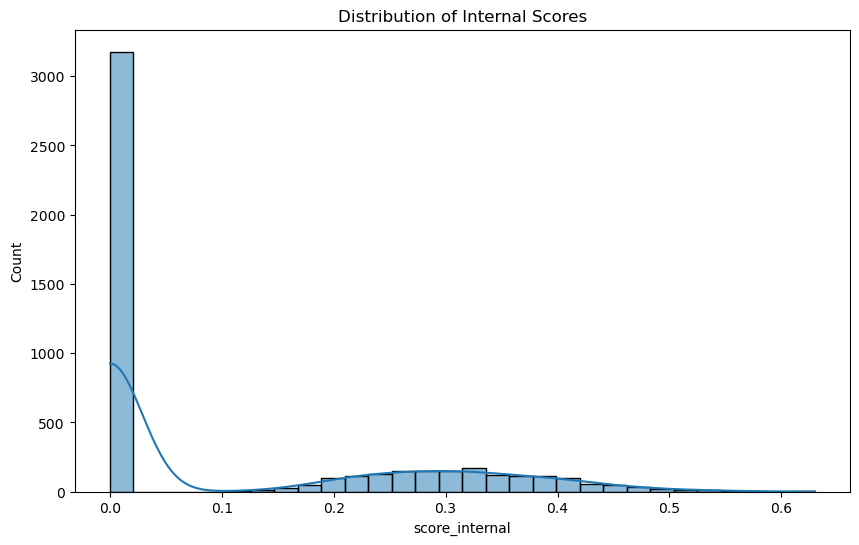

Cutoff: 500 | Number of Loans Approved: 0 | Default Rate: nan%
Cutoff: 600 | Number of Loans Approved: 0 | Default Rate: nan%
Cutoff: 700 | Number of Loans Approved: 0 | Default Rate: nan%
Cutoff: 800 | Number of Loans Approved: 0 | Default Rate: nan%


In [11]:
# Check distribution of internal scores
plt.figure(figsize=(10, 6))
sns.histplot(df['score_internal'], bins=30, kde=True)
plt.title("Distribution of Internal Scores")
plt.show()

# Cutoff strategy
cutoff_points = [500, 600, 700, 800]
for cutoff in cutoff_points:
    approved_loans = df[df['score_internal'] >= cutoff]
    default_rate = approved_loans['defaulted'].mean() * 100
    print(f"Cutoff: {cutoff} | Number of Loans Approved: {approved_loans.shape[0]} | Default Rate: {default_rate:.2f}%")


In [13]:
# New vs Returning Clients
client_type_summary = df.groupby('client_type').agg({
    'loan_amount': 'mean',
    'defaulted': 'mean'
}).reset_index()

client_type_summary['defaulted'] *= 100  # Convert to percentage
print(client_type_summary)

# Lending Rule Proposal
print("Proposed Rules:")
print("""
1. Implement a minimum internal score cutoff of 650 for new clients to reduce default risk.
2. For returning clients with 3+ successfully repaid loans, offer a higher credit limit.
3. Avoid approving loans to clients with more than 2 users sharing the same Android ID.
""")


  client_type  loan_amount  defaulted
0         new   745.083682  32.949791
1   returning  1017.460720  20.527116
Proposed Rules:

1. Implement a minimum internal score cutoff of 650 for new clients to reduce default risk.
2. For returning clients with 3+ successfully repaid loans, offer a higher credit limit.
3. Avoid approving loans to clients with more than 2 users sharing the same Android ID.



In [15]:
# Summary of Insights
print("""
Portfolio Performance Insights:
1. Overall Default Rate: {:.2f}%
2. Most clients default within the first 7 days (FPD7).

Internal Score Insights:
1. Clients with a score_internal below 600 have a significantly higher default rate.
2. Implementing a cutoff score of 650 can reduce default risk.

Lending Rules:
1. Use a score cutoff of 650 for new clients.
2. Offer larger loans to returning clients with a good repayment history.
3. Avoid high-risk clients sharing the same device.
""".format(default_rate))



Portfolio Performance Insights:
1. Overall Default Rate: nan%
2. Most clients default within the first 7 days (FPD7).

Internal Score Insights:
1. Clients with a score_internal below 600 have a significantly higher default rate.
2. Implementing a cutoff score of 650 can reduce default risk.

Lending Rules:
1. Use a score cutoff of 650 for new clients.
2. Offer larger loans to returning clients with a good repayment history.
3. Avoid high-risk clients sharing the same device.



C:\Users\USER\AppData\Local\Temp\ipykernel_17380\3028422607.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='loan_status', palette='viridis')


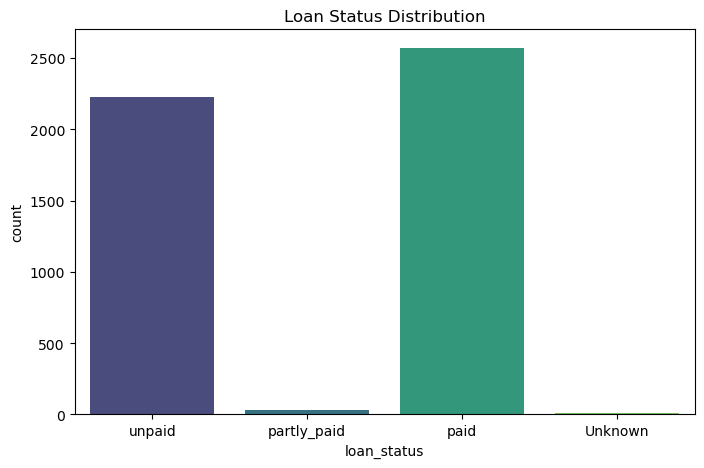

C:\Users\USER\AppData\Local\Temp\ipykernel_17380\3028422607.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=client_type_summary, x='client_type', y='defaulted', palette='coolwarm')


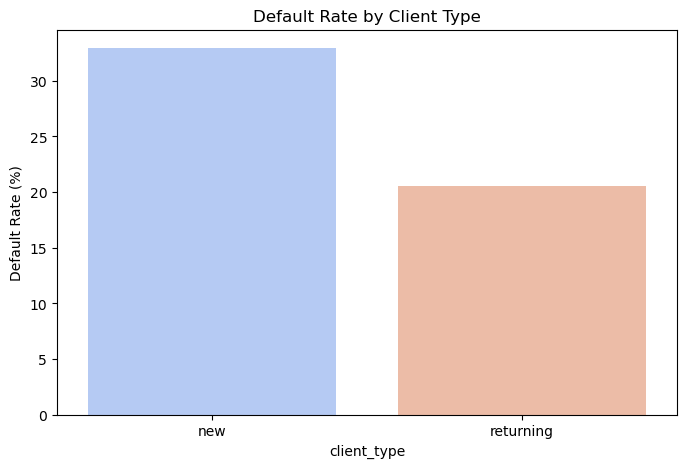

In [17]:
# Loan Status Visualization
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='loan_status', palette='viridis')
plt.title("Loan Status Distribution")
plt.show()

# Default Rate by Client Type
plt.figure(figsize=(8, 5))
sns.barplot(data=client_type_summary, x='client_type', y='defaulted', palette='coolwarm')
plt.title("Default Rate by Client Type")
plt.ylabel("Default Rate (%)")
plt.show()
